Contrast	Mean_hi±SEM	Mean_lo±SEM	t-stat	 df	p_corr
AMY-HI vs AMY-LO	0.969±0.111	0.531±0.080	3.189	126	0.0036
MD-HI vs MD-LO	0.698±0.092	1.143±0.106	-3.166	124	0.0036


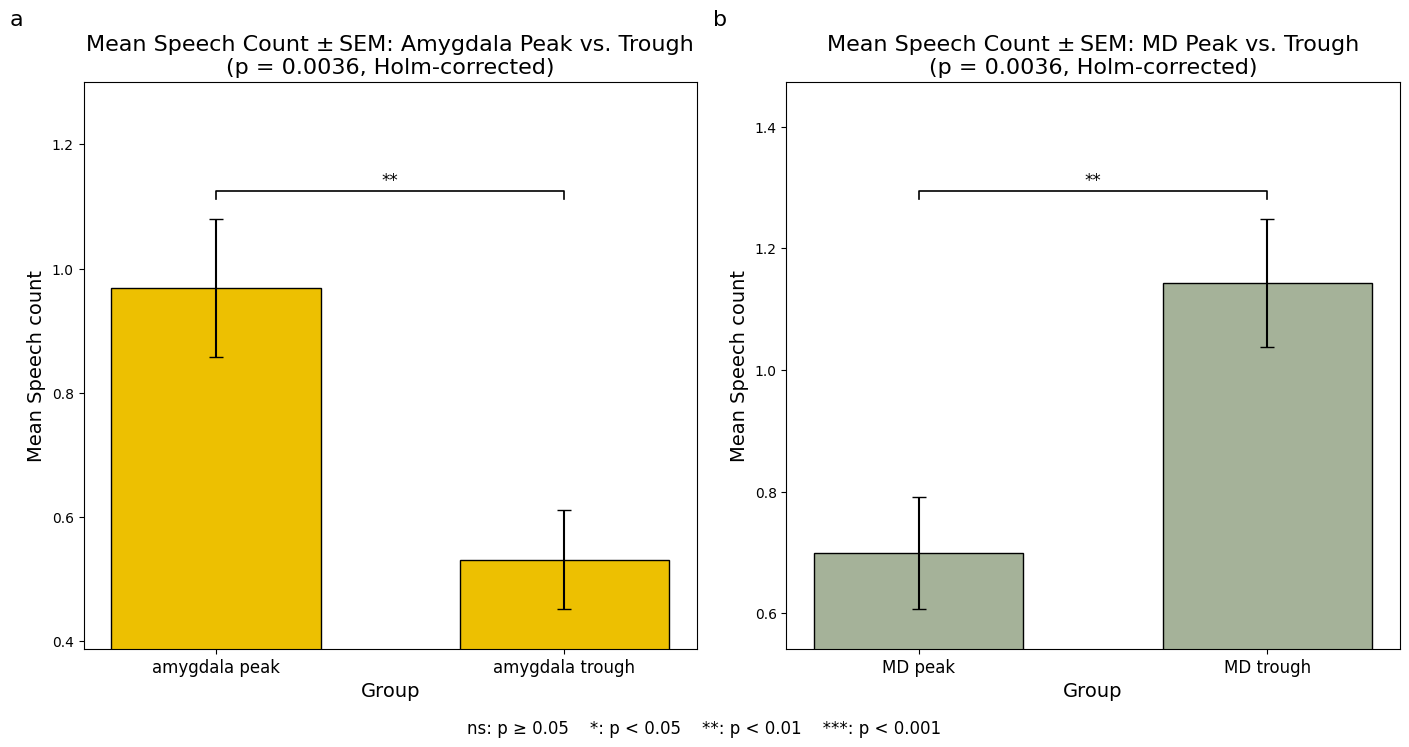

In [4]:
## this code reads in the sound_labels_per_clip csv and performs two t-tests:
## one for amygdala peaks versus troughs, and one for MD peaks versus troughs. 
## (it also corrects for multiple comparisons using Holm-Bonferroni)
## it also outputs two graphs in light blue, one for amygdala and one for MD. 
## you can adapt "Speech" to calculate the t-tests for any other sound. 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import matplotlib as mpl
from statsmodels.stats.multitest import multipletests

# style that I want
mpl.rcParams.update({
    "figure.facecolor": "white",   # whole figure background
    "axes.facecolor":   "white",   # axes panel background
    "axes.grid": False             # kill the default grid
})


# 1. Read data
df = pd.read_csv("sound_labels_per_clip.csv")

# 2. Define contrasts and mappings
comparisons = [("AMY-HI", "AMY-LO"), ("MD-HI", "MD-LO")]
label_map = {
    "AMY-HI": "amygdala peak",
    "AMY-LO": "amygdala trough",
    "MD-HI":  "MD peak",
    "MD-LO":  "MD trough"
}
colors = {"AMY": "#EDC001", "MD": "#A5B299"}

# 3. Run t-tests and collect results
results = []
raw_p = []
for hi, lo in comparisons:
    subset = df[df["AM_Label"].isin([hi, lo])]
    desc = subset.groupby("AM_Label")["Speech"].agg(["mean", "sem"]).reindex([hi, lo])

    t_stat, p_val = ttest_ind(
        subset.loc[subset["AM_Label"] == hi, "Speech"],
        subset.loc[subset["AM_Label"] == lo, "Speech"],
        equal_var=True, nan_policy="omit"
    )
    n1 = subset[subset["AM_Label"] == hi].shape[0]
    n2 = subset[subset["AM_Label"] == lo].shape[0]
    dfree = n1 + n2 - 2

    results.append({
        "hi": hi,
        "lo": lo,
        "desc": desc,
        "t": t_stat,
        "df": dfree,
        "p_raw": p_val
    })
    raw_p.append(p_val)

# 4. Holm correction
_, p_corr, _, _ = multipletests(raw_p, method="holm")
for r, pc in zip(results, p_corr):
    r["p_corr"] = pc

# 5. Print summary table
print("Contrast\tMean_hi±SEM\tMean_lo±SEM\tt-stat\t df\tp_corr")
for r in results:
    hi, lo = r["hi"], r["lo"]
    desc, t_stat, dfree, pc = r["desc"], r["t"], r["df"], r["p_corr"]
    mean_hi, sem_hi = desc.loc[hi, ["mean", "sem"]]
    mean_lo, sem_lo = desc.loc[lo, ["mean", "sem"]]
    print(f"{hi} vs {lo}\t"
          f"{mean_hi:.3f}±{sem_hi:.3f}\t"
          f"{mean_lo:.3f}±{sem_lo:.3f}\t"
          f"{t_stat:.3f}\t"
          f"{dfree}\t"
          f"{pc:.4g}")

# 6. Significance‐stars helper
def stars(p):
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return "ns"

# 7. Make the combined figure
fig, axes = plt.subplots(1, 2, figsize=(14, 7), constrained_layout=True)

for ax, r in zip(axes, results):
    hi, lo = r["hi"], r["lo"]
    desc, pc = r["desc"], r["p_corr"]
    grp = hi.split("-")[0]  # "AMY" or "MD"
    x = np.arange(2)

    # bars
    ax.bar(
        x, desc["mean"], yerr=desc["sem"],
        width=0.6,
        color=colors[grp],
        edgecolor="black",
        capsize=5
    )
    ax.axhline(0, color="gray", linestyle="--", linewidth=1)

    # bracket & stars
    y_top = (desc["mean"] + desc["sem"]).max()
    y_bot = (desc["mean"] - desc["sem"]).min()
    bracket_y = y_top + 0.05 * (y_top - y_bot)
    h = 0.02 * (y_top - y_bot)
    ax.plot([0, 0, 1, 1],
            [bracket_y, bracket_y+h, bracket_y+h, bracket_y],
            color="black", lw=1.2)
    ax.text(0.5, bracket_y + h*1.2,
            stars(pc),
            ha="center", va="bottom", fontsize=12)

    # expand y-limits
    y_range = y_top - y_bot
    ax.set_ylim(y_bot - 0.1*y_range, bracket_y + 0.3*y_range)

    # labels & title
    ax.set_xticks(x)
    ax.set_xticklabels([label_map[hi], label_map[lo]], fontsize=12)
    ax.set_ylabel("Mean Speech count", fontsize=14)
    ax.set_xlabel("Group", fontsize=14)
    region = "Amygdala" if grp == "AMY" else "MD"
    ax.set_title(
        f"Mean Speech Count ± SEM: {region} Peak vs. Trough\n"
        f"(p = {pc:.4g}, Holm-corrected)",
        fontsize=16
    )

# panel labels
axes[0].text(-0.12, 1.10, "a", transform=axes[0].transAxes, fontsize=16)
axes[1].text(-0.12, 1.10, "b", transform=axes[1].transAxes, fontsize=16)

# significance key (below x-axis)
fig.text(
    0.5, -0.04,
    "ns: p ≥ 0.05    *: p < 0.05    **: p < 0.01    ***: p < 0.001",
    ha="center", fontsize=12
)

plt.show()
